Step 5: Optimization with uncertain conversion rates, 𝛼 ratios, and number of items sold per product,
uncertain graph weight s

In [1]:
#uncertain graph weights (different click influence probabilities between the products for each user)
#homogeneous users (one class with small variability)
#uncertain alphas
#uncertain number of items sold per product
#uncertain conversion rates

In [26]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from Environment.E_commerce import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.TS_Learner_poisson import *
from Algorithms.Learner_Environment import *
from Algorithms.SWTS_Learner import *
from Algorithms.UCB_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.Estimate_click_probabilities import *
from Algorithms.SW_UCB_Learner import SW_UCB
from Algorithms.CD_UCB_Learner import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
P1 = Product(0,[9,12,13,14.5],[ 1.,  4,  5., 6.5])
P2 = Product(1,[20,22.5,23,24.5],[ 4.,  6.5, 7., 8.5])
P3 = Product(2,[30,31.5,34,34.5],[ 6.,  7.5, 10., 10.5])
P4 = Product(3,[40,42.5,43,46.5],[ 8., 10.5, 11., 14.5])
P5 = Product(4,[50,51.5,53,54.5],[10., 11.5, 13., 14.5])

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = E_commerce()
E.set_lambda(0.5)
E.set_products(products)

#Ecommerce graph weights are uncertain, for each user they are different, but the slots are fixed by the Ecommerce
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

In [4]:
#Random algorithm which for each round pulls a random choice 
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms


n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):
        #if (d==30):
        #    User0.setprice()
        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i] 
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])#expected_units_sold_per_product[i])#
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms


_______________________________________________
Conversion rates
[[0.86608823 0.60924064 0.51224508 0.38379014]
 [0.79080749 0.56391525 0.51584067 0.38583686]
 [0.79036782 0.65293498 0.40839703 0.37308809]
 [0.78923949 0.5659224  0.52146642 0.22520458]
 [0.75625034 0.5951842  0.43184363 0.31123526]]
_______________________________________________
Expected rewards per arm
[[ 1.73402991  4.84693313  5.06393787  4.91565168]
 [ 3.15184296  3.62306044  3.57108711  3.23047513]
 [14.17672512 14.53441291 11.99811047 11.53537891]
 [18.92585065 17.71890694 17.09794002  9.66843575]
 [ 7.56931162  6.84753092  5.61154378  4.50567612]]
_______________________________________________
Expected units sold per arm
[[2. 2. 2. 2.]
 [1. 1. 1. 1.]
 [3. 3. 3. 3.]
 [3. 3. 3. 3.]
 [1. 1. 1. 1.]]
_______________________________________________
Best configuration [2. 1. 1. 0. 0.]
Optimal cumulative expected reward per round
50.05900574350898


## SW-TS (skip it)

It was not asked, but I wrote it. Unfortunately, it is giving some errors sometimes.

In [157]:
#Comparison between TS and SW-TS
from Algorithms.SWTS_Learner import *
n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 10

window_size = 100

swts_rewards_per_experiment = []
ts_rewards_per_experiment = []

swts_pulls_per_arm_per_experiment = []
ts_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)
    swts_learner = SW_TS(n_arms, window_size)

    for d in range(n_days):

        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward,env.clicks_current_day, env.purchases_current_day,  env.daily_units)

        pulled_arm = swts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        swts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    swts_rewards_per_experiment.append(swts_learner.collected_rewards)
    ts_rewards_per_experiment.append(ts_learner.collected_rewards)


    swts_pulls_per_arm_per_experiment.append(swts_learner.counter_per_arm)
    ts_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)


[[[4. 0.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]]
[[[4. 0.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[6. 2.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]]
[[[4. 0.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[6. 2.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[5. 0.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]]
[[[4. 0.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[6. 2.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[5. 0.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[7. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]]
[[[4. 0.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[6. 2.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[5. 0.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[7. 1.]
  [1. 1.]
  [1. 1.]
  [1

TypeError: 'NoneType' object is not subscriptable

/Users/lucamainini/opt/anaconda3/envs/math_environment/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lucamainini/opt/anaconda3/envs/math_environment/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lucamainini/opt/anaconda3/envs/math_environment/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lucamainini/opt/anaconda3/envs/math_environment/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


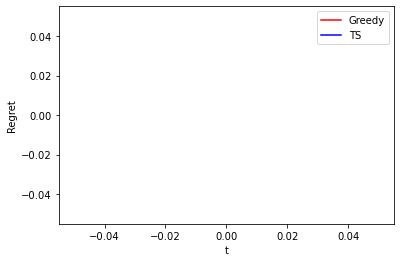

In [153]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - swts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'b')
plt.legend(["Greedy","TS","UCB","random"])
plt.show()

## TEST IF FUNCTION CORRECTLY WORKS (skip it)

In [ ]:
n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 10

window_size = 100

swts_rewards_per_experiment = []
ucb_rewards_per_experiment = []

ts_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []

env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
ts_learner = TS_poisson(n_arms=n_arms)
swts_learner = SW_TS(n_arms, window_size)


pulled_arm = ts_learner.pull_arm(env.margins_matrix)
print(pulled_arm)
reward = env.round(pulled_arm)
#swts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)
swts_learner.t += 1
swts_learner.update_observations(pulled_arm, reward)

In [62]:
#print(swts_learner.beta_parameters)
print(env.daily_units)
print(env.purchases_current_day)
print(pulled_arm)

[6. 4. 9. 6. 3.]
[3. 4. 3. 2. 3.]
[0 0 0 0 0]


In [96]:
swts_learner.pulled_arms = [np.array([]) for j in range(5)]
swts_learner.clicks = [[[] for i in range(n_arms)] for j in range(5)]
swts_learner.purchases = [[[] for i in range(n_arms)] for j in range(5)]
swts_learner.n_bought_products =[[[] for i in range(n_arms)] for j in range(5)]
swts_learner.beta_parameters = np.array([np.ones((n_arms, 2))] * 5)
swts_learner.expected_rewards = np.zeros([5, n_arms])

'''
print(swts_learner.pulled_arms)
print(swts_learner.clicks)
print(swts_learner.purchases)
print(swts_learner.n_bought_products)
'''

#print(pulled_arm)
for i in range(5):
    swts_learner.pulled_arms[i] = np.append(swts_learner.pulled_arms[i], pulled_arm[i])
    for arm in range(n_arms):
        if arm == int(pulled_arm[i]):
            swts_learner.clicks[i][arm].append(env.clicks_current_day[i])
            swts_learner.purchases[i][arm].append(env.purchases_current_day[i])
            swts_learner.n_bought_products[i][arm].append(env.daily_units[i])
        else:
            swts_learner.clicks[i][arm].append(0)
            swts_learner.purchases[i][arm].append(0)
            swts_learner.n_bought_products[i][arm].append(0)

print('clicks: ',swts_learner.clicks)
print('purchases',swts_learner.purchases)
print('bought products',swts_learner.n_bought_products)

# cum_purchases = [[[0] for i in range(swts_learner.n_arms)] for j in range(5)]
# cum_clicks = [[[0] for i in range(swts_learner.n_arms)] for j in range(5)]
# n_bought_products = [[[0] for i in range(swts_learner.n_arms)] for j in range(5)]

purchase = env.purchases_current_day
click = env.clicks_current_day

for i in range(5):
    print('product',i)
    for arm in range(swts_learner.n_arms):
        n_samples = np.sum(swts_learner.pulled_arms[i][-swts_learner.window_size:] == arm)
        print('arm:',arm, ', n_samples:', n_samples)
        cum_purchases = np.sum(swts_learner.purchases[i][arm][-n_samples:])  if n_samples > 0 else 0
        cum_clicks = np.sum(swts_learner.clicks[i][arm][-n_samples:]) if n_samples > 0 else 0
        n_bought_products = np.sum(swts_learner.n_bought_products[i][arm][-n_samples:]) if n_samples > 0 else 0

        swts_learner.beta_parameters[i][arm, 0] = cum_purchases if n_samples > 0 else 1
        swts_learner.beta_parameters[i][arm, 1] = cum_clicks - cum_purchases if n_samples > 0 else 1

        print('cum_purchases: ',cum_purchases)
        print('cum_clicks',cum_clicks)
        print('beta_parameters',swts_learner.beta_parameters)


    #print('n_bought_products',n_bought_products)


to_continue=0
if to_continue:
    pulled_arm = ts_learner.pull_arm(env.margins_matrix)
    print(pulled_arm)
    reward = env.round(pulled_arm)
#swts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)
    swts_learner.t += 1
    swts_learner.update_observations(pulled_arm, reward)
    for i in range(5):
        swts_learner.pulled_arms[i] = np.append(swts_learner.pulled_arms[i], pulled_arm[i])
        for arm in range(n_arms):
            if arm == int(pulled_arm[i]):
                swts_learner.clicks[i][arm].append(env.clicks_current_day[i])
                swts_learner.purchases[i][arm].append(env.purchases_current_day[i])
                swts_learner.n_bought_products[i][arm].append(env.daily_units[i])
            else:
                swts_learner.clicks[i][arm].append(0)
                swts_learner.purchases[i][arm].append(0)
                swts_learner.n_bought_products[i][arm].append(0)


    print(swts_learner.clicks)
    print(swts_learner.purchases)
    print(swts_learner.n_bought_products)

'''


cum_purchases = [0 for j in range(5)]
cum_clicks = [0 for j in range(5)]
cum_bought_products = [0 for j in range(5)]

# print(cum_purchases)
# print(cum_clicks)
# print(cum_bought_products)

'''

clicks:  [[[8.0], [0], [0], [0]], [[6.0], [0], [0], [0]], [[5.0], [0], [0], [0]], [[7.0], [0], [0], [0]], [[3.0], [0], [0], [0]]]
purchases [[[4.0], [0], [0], [0]], [[4.0], [0], [0], [0]], [[4.0], [0], [0], [0]], [[5.0], [0], [0], [0]], [[3.0], [0], [0], [0]]]
bought products [[[8.0], [0], [0], [0]], [[4.0], [0], [0], [0]], [[12.0], [0], [0], [0]], [[15.0], [0], [0], [0]], [[3.0], [0], [0], [0]]]
product 0
arm: 0 , n_samples: 1
cum_purchases:  4.0
cum_clicks 8.0
beta_parameters [[[4. 4.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]]
arm: 1 , n_samples: 0
cum_purchases:  0
cum_clicks 0
beta_parameters [[[4. 4.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]]
arm: 2 , n_samples: 0
cum_pu

'\n\n\ncum_purchases = [0 for j in range(5)]\ncum_clicks = [0 for j in range(5)]\ncum_bought_products = [0 for j in range(5)]\n\n# print(cum_purchases)\n# print(cum_clicks)\n# print(cum_bought_products)\n\n'

## SW-UCB

### Simulation in a static environment

In [26]:
#Comparison between SW-UCB and UCB

n_arms = 4
num_users = 100
n_days = 20
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 1

window_size = 10

sw_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

sw_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    sw_UCB_learner = SW_UCB(n_arms, window_size)

    for d in range(n_days):

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = sw_UCB_learner.pull_arm()
        reward = env.round(pulled_arm, )
        sw_UCB_learner.update(pulled_arm, reward)

    sw_ucb_rewards_per_experiment.append(sw_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    sw_ucb_pulls_per_arm_per_experiment.append(sw_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

-----------time  1
pulled  [0 0 0 0 0]
product  0
arm 0 , n 0
rewards till now:  [2.0]
expected rewards [[2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
arm 1 , n 0
rewards till now:  []
expected rewards [[ 2. nan  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
arm 2 , n 0
rewards till now:  []
expected rewards [[ 2. nan nan  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
arm 3 , n 0
rewards till now:  []
expected rewards [[ 2. nan nan nan]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
product  1
arm 0 , n 0
rewards till now:  [4.0]
expected rewards [[ 2. nan nan nan]
 [ 4.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
arm 1 , n 0
rewards till now:  []
expected rewards [[ 2. nan nan nan]
 [ 4. nan  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
arm 2 , n 0
rewards till now:  []
expected rewards [[ 2. nan nan nan]
 

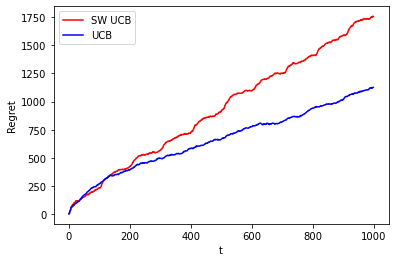

In [126]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - sw_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["SW UCB","UCB"])
plt.show()

Come previsto, SW UCB si comporta peggio di UCB (in un AMBIENTE STATICO).

## Simulation in a changing environment

In [36]:
#Comparison between SW-UCB and UCB

n_arms = 4
num_users = 100
n_days = 100
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 1

days_of_change = [50, 70]

window_size = 50

sw_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

sw_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    sw_UCB_learner = SW_UCB(n_arms, window_size)

    for d in range(n_days):
        for day_of_change in days_of_change:
            if d==day_of_change:
                env.abrupt_change([0],1.20)

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = sw_UCB_learner.pull_arm()
        reward = env.round(pulled_arm, )
        sw_UCB_learner.update(pulled_arm, reward)

    sw_ucb_rewards_per_experiment.append(sw_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    sw_ucb_pulls_per_arm_per_experiment.append(sw_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

-----------time  1
pulled  [0 0 0 0 0]
-----------time  2
pulled  [1 1 1 1 1]
-----------time  3
pulled  [2 2 2 2 2]
-----------time  4
pulled  [3 3 3 3 3]
-----------time  5
pulled  [0 0 0 0 0]
-----------time  6
pulled  [1 1 1 1 1]
-----------time  7
pulled  [2 2 2 2 2]
-----------time  8
pulled  [3 3 3 3 3]
-----------time  9
pulled  [3. 3. 2. 3. 3.]
-----------time  10
pulled  [3. 3. 1. 3. 3.]
-----------time  11
pulled  [3. 3. 2. 1. 3.]
-----------time  12
pulled  [3. 3. 2. 1. 3.]
-----------time  13
pulled  [2. 3. 2. 3. 3.]
-----------time  14
pulled  [2. 3. 2. 2. 0.]
-----------time  15
pulled  [3. 3. 2. 2. 3.]
-----------time  16
pulled  [3. 3. 2. 2. 3.]
-----------time  17
pulled  [3. 3. 2. 2. 3.]
-----------time  18
pulled  [3. 3. 2. 3. 3.]
-----------time  19
pulled  [3. 3. 2. 2. 3.]
-----------time  20
pulled  [3. 3. 2. 3. 3.]
-----------time  21
pulled  [3. 3. 2. 2. 3.]
-----------time  22
pulled  [3. 3. 2. 3. 3.]
-----------time  23
pulled  [1. 3. 2. 1. 3.]
-----------tim

/Users/lucamainini/opt/anaconda3/envs/math_environment/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lucamainini/opt/anaconda3/envs/math_environment/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 53
pulled  [2. 3. 2. 2. 3.]
-----------time  54
pulled  [1. 3. 2. 2. 3.]
-----------time  55
pulled  [3. 3. 2. 2. 3.]
-----------time  56
pulled  [0. 0. 2. 2. 3.]
-----------time  57
pulled  [0. 1. 2. 2. 1.]
-----------time  58
pulled  [3. 2. 2. 0. 1.]
-----------time  59
pulled  [1. 2. 3. 0. 3.]
-----------time  60
pulled  [3. 3. 3. 0. 1.]
-----------time  61
pulled  [3. 3. 3. 2. 3.]
-----------time  62
pulled  [3. 3. 3. 1. 1.]
-----------time  63
pulled  [3. 3. 3. 2. 1.]
-----------time  64
pulled  [3. 3. 3. 1. 3.]
-----------time  65
pulled  [2. 3. 3. 2. 3.]
-----------time  66
pulled  [2. 3. 3. 1. 3.]
-----------time  67
pulled  [2. 3. 3. 2. 3.]
-----------time  68
pulled  [3. 3. 3. 2. 3.]
-----------time  69
pulled  [3. 3. 3. 2. 3.]
-----------time  70
pulled  [3. 3. 3. 2. 3.]
Abrupt change
class User 0 has changed: its new average reservation price is [ 89.16100448 178.32200897 267.48301345 356.64401793 445.80502241]
-----------time  71
pulled  [3. 3. 3. 2. 3.]
-----------time  

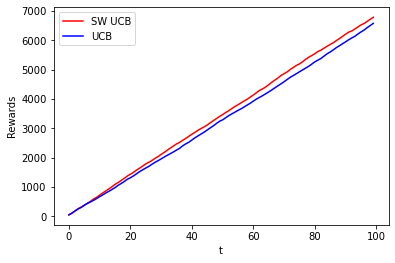

In [37]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Rewards")
plt.plot(np.cumsum(np.mean(sw_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["SW UCB","UCB"])
plt.show()

Questa volta SW-UCB si comporta meglio!

## SD1-UCB

In [17]:
#Comparison between SD1-UCB and UCB
# static environment

n_arms = 4
num_users = 100
n_days = 20
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 1

window_size = 10

cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CD1_UCB(n_arms, window_size)

    for d in range(n_days):

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        reward = env.round(pulled_arm, )
        cd_UCB_learner.update(pulled_arm, reward)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

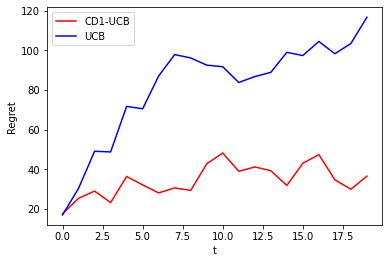

In [18]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - cd_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["CD1-UCB","UCB"])
plt.show()

Abrupt change
class User 0 has changed: its new average reservation price is [ 51.59780352 103.19560704 154.79341056 206.39121408 257.9890176 ]
Abrupt change
class User 0 has changed: its new average reservation price is [ 61.91736422 123.83472845 185.75209267 247.6694569  309.58682112]


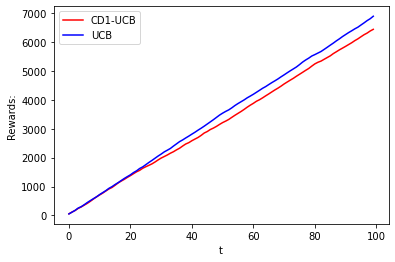

In [15]:
#Comparison between SD1-UCB and UCB
# dynamic environment

n_arms = 4
num_users = 100
n_days = 100
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 1

window_size = 50

days_of_change = [50, 70]


cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CD1_UCB(n_arms, window_size)

    for d in range(n_days):
        for day_of_change in days_of_change:
            if d==day_of_change:
                env.abrupt_change([0],1.20)

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        reward = env.round(pulled_arm, )
        cd_UCB_learner.update(pulled_arm, reward)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Rewards:")
plt.plot(np.cumsum(np.mean(cd_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["CD1-UCB","UCB"])
plt.show()

## CU-SUM UCB

day  0
[0 0 0 0 0]
day  1
[1 1 1 1 1]
day  2
[2 2 2 2 2]
day  3
[3 3 3 3 3]
day  4
[0 0 0 0 0]
day  5
[1 1 1 1 1]
day  6
[2 2 2 2 2]
day  7
[3 3 3 3 3]
day  8
[3. 3. 2. 2. 2.]
day  9
[3. 3. 2. 2. 2.]
day  10
[3. 3. 2. 2. 3.]
day  11
[3. 3. 3. 2. 1.]
day  12
[3. 3. 3. 2. 1.]
day  13
[3. 3. 3. 2. 1.]
day  14
[3. 3. 2. 2. 1.]
day  15
[3. 3. 2. 2. 1.]
day  16
[3. 3. 2. 2. 2.]
day  17
[3. 3. 2. 2. 1.]
day  18
[3. 3. 2. 2. 2.]
day  19
[3. 3. 2. 2. 1.]


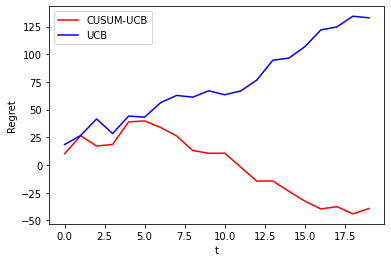

In [32]:
#Comparison between CU-SUM UCB and UCB
# static environment

n_arms = 4
num_users = 100
n_days = 20
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 1

window_size = 10

cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CUSUM_UCB(n_arms)

    for d in range(n_days):
        print('day ', d)
        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        print(pulled_arm)
        reward = env.round(pulled_arm, )
        cd_UCB_learner.update(pulled_arm, reward)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - cd_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["CUSUM-UCB", "UCB"])
plt.show()

--------day-------- 0
estimated probability  0.8333333333333334
running CUSUM algorithm
troppo presto
estimated probability  0.8333333333333334
running CUSUM algorithm
troppo presto
estimated probability  0.8
running CUSUM algorithm
troppo presto
estimated probability  1.0
running CUSUM algorithm
troppo presto
estimated probability  1.0
running CUSUM algorithm
troppo presto
--------day-------- 1
estimated probability  0.5
running CUSUM algorithm
troppo presto
estimated probability  0.3333333333333333
running CUSUM algorithm
troppo presto
estimated probability  0.75
running CUSUM algorithm
troppo presto
estimated probability  0.8333333333333334
running CUSUM algorithm
troppo presto
estimated probability  1.0
running CUSUM algorithm
troppo presto
--------day-------- 2
estimated probability  1.0
running CUSUM algorithm
troppo presto
estimated probability  0.6666666666666666
running CUSUM algorithm
troppo presto
estimated probability  1.0
running CUSUM algorithm
troppo presto
estimated pro

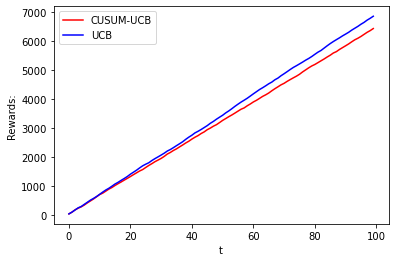

In [22]:
#Comparison between CUSUM-UCB and UCB
# dynamic environment

n_arms = 4
num_users = 100
n_days = 100
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 1

window_size = 50

days_of_change = [50, 70]


cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CUSUM_UCB(n_arms, window_size)

    for d in range(n_days):
        print('--------day--------', d)
        for day_of_change in days_of_change:
            if d==day_of_change:
                env.abrupt_change([0],1.20)

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        reward = env.round(pulled_arm)
        cd_UCB_learner.update(pulled_arm, reward, env.purchases_current_day,env.clicks_current_day)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Rewards:")
plt.plot(np.cumsum(np.mean(cd_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["CUSUM-UCB","UCB"])
plt.show()

--------day-------- 0
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
--------day-------- 1
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
--------day-------- 2
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
--------day-------- 3
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
--------day-------- 4
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM al

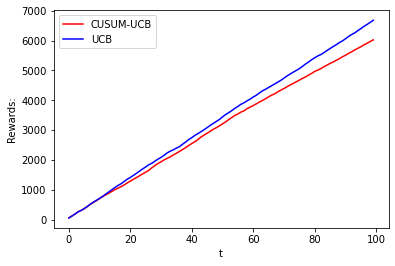

In [35]:
#Comparison between CUSUM-UCB and UCB
# dynamic environment

n_arms = 4
num_users = 100
n_days = 100
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 1

window_size = 50

days_of_change = [50, 70]


cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CUSUM_UCB(n_arms, window_size)

    for d in range(n_days):
        print('--------day--------', d)
        for day_of_change in days_of_change:
            if d==day_of_change:
                env.abrupt_change([0],1.20)

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        reward = env.round(pulled_arm)
        cd_UCB_learner.update(pulled_arm, reward, env.purchases_current_day,env.clicks_current_day)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Rewards:")
plt.plot(np.cumsum(np.mean(cd_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["CUSUM-UCB","UCB"])
plt.show()